# 필요 패키지 설치

In [1]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 13.2 MB/s eta 0:00:00


In [2]:
!pip install koreanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 21.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import numpy as np
import sklearn
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

In [4]:
sampled_data = pd.read_csv('/content/sample_data/data (2).csv',encoding='euc-kr')
# Load the data_without_sampled csv file
data_without_sampled = pd.read_csv('/content/sample_data/data_without_sampled (1).csv', encoding='utf-8-sig')



In [5]:
# Check for missing values in sampled_data
missing_values_sampled = sampled_data.isnull().sum()

# Display basic statistical information for sampled_data
stats_sampled = sampled_data.describe()

missing_values_sampled, stats_sampled


(세대수          0
 관측연월         0
 전기사용량        0
 탄소발생량        0
 일일전기사용량      0
 평균기온(°C)     0
 평균상대습도(%)    0
 평균풍속(m/s)    0
 dtype: int64,
                  세대수           관측연월         전기사용량         탄소발생량  \
 count  100512.000000  100512.000000  1.005120e+05  1.005120e+05   
 mean      738.231584  201736.379378  2.459996e+05  1.033198e+05   
 std       732.351838     177.856526  3.046560e+05  1.279555e+05   
 min        57.000000  201501.000000  0.000000e+00  0.000000e+00   
 25%       333.000000  201602.000000  7.969700e+04  3.347274e+04   
 50%       505.000000  201709.000000  1.649730e+05  6.928866e+04   
 75%       860.000000  201905.000000  2.930232e+05  1.230698e+05   
 max      9510.000000  202012.000000  4.559743e+06  1.915092e+06   
 
              일일전기사용량       평균기온(°C)      평균상대습도(%)      평균풍속(m/s)  
 count  100512.000000  100512.000000  100512.000000  100512.000000  
 mean       11.506222      13.115849      59.010128       2.249305  
 std         9.251500      10.072406

In [6]:
# Check for missing values in data_without_sampled
missing_values_without_sampled = data_without_sampled.isnull().sum()

# Display basic statistical information for data_without_sampled
stats_without_sampled = data_without_sampled.describe()

missing_values_without_sampled, stats_without_sampled


(시군구코드        0
 법정동코드        0
 세대수          0
 관측연월         0
 전기사용량        0
 탄소발생량        0
 일일전기사용량      0
 평균기온(°C)     0
 평균상대습도(%)    0
 평균풍속(m/s)    0
 dtype: int64,
               시군구코드         법정동코드           세대수           관측연월         전기사용량  \
 count  90512.000000  90512.000000  90512.000000   90512.000000  9.051200e+04   
 mean   11452.851058  10965.654278    737.409349  201736.358339  2.457366e+05   
 std      170.750923   1178.270799    734.573902     177.897511  3.057170e+05   
 min    11110.000000  10100.000000     57.000000  201501.000000  0.000000e+00   
 25%    11320.000000  10300.000000    332.000000  201602.000000  7.945775e+04   
 50%    11440.000000  10600.000000    503.000000  201709.000000  1.647150e+05   
 75%    11590.000000  11100.000000    859.000000  201905.000000  2.921262e+05   
 max    11740.000000  18700.000000   9510.000000  202012.000000  4.559743e+06   
 
               탄소발생량       일일전기사용량      평균기온(°C)     평균상대습도(%)     평균풍속(m/s)  
 count  9.05120

# 데이터 전처리 - 원핫인코딩

In [7]:
from sklearn.preprocessing import OneHotEncoder

# Split '관측연월' into 'Year' and 'Month'
sampled_data['Year'] = (sampled_data['관측연월'] // 100).astype(int)
sampled_data['Month'] = (sampled_data['관측연월'] % 100).astype(int)

# Drop the original '관측연월' column
sampled_data.drop('관측연월', axis=1, inplace=True)

# One-hot encode the categorical variables: '시군구코드' and '법정동코드'


In [8]:
# Split '관측연월' into 'Year' and 'Month'
data_without_sampled['Year'] = (data_without_sampled['관측연월'] // 100).astype(int)
data_without_sampled['Month'] = (data_without_sampled['관측연월'] % 100).astype(int)

# Drop the original '관측연월' column
data_without_sampled.drop('관측연월', axis=1, inplace=True)

# One-hot encode the categorical variables: '시군구코드' and '법정동코드'
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_features = encoder.fit_transform(data_without_sampled[['시군구코드', '법정동코드']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['시군구코드', '법정동코드']))

# Concatenate the one-hot encoded columns to the original dataframe
data_without_sampled = pd.concat([data_without_sampled, encoded_df], axis=1)

# Drop the original '시군구코드' and '법정동코드' columns
data_without_sampled.drop(['시군구코드', '법정동코드'], axis=1, inplace=True)

data_without_sampled.head()


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,세대수,전기사용량,탄소발생량,일일전기사용량,평균기온(°C),평균상대습도(%),평균풍속(m/s),Year,Month,시군구코드_11140,...,법정동코드_13900,법정동코드_16200,법정동코드_16500,법정동코드_16800,법정동코드_17100,법정동코드_17300,법정동코드_17400,법정동코드_17500,법정동코드_18300,법정동코드_18700
0,150,405721,170402.82,90.160222,-0.9,56,2.6,2015,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,150,415926,174688.92,92.428000,1.0,59,2.9,2015,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,150,354563,148916.46,78.791778,6.3,45,3.1,2015,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,150,364181,152956.02,80.929111,13.3,55,3.1,2015,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,150,340378,142958.76,75.639556,18.9,53,3.0,2015,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 학습 데이터 분리(8:2)

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Features and target variable
# 1. Features and target variable selection
all_features = sampled_data.columns.drop('일일전기사용량')
target = '일일전기사용량'

# 2. Splitting the data into training and testing sets
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(sampled_data[all_features], sampled_data[target], test_size=0.2, random_state=42)

In [10]:
rgb_regressor_all_features = XGBRegressor(n_estimators=150, random_state=42)
rgb_regressor_all_features.fit(X_train_all, y_train_all)
y_pred_all = rgb_regressor_all_features.predict(X_test_all)
mse_all = mean_squared_error(y_test_all, y_pred_all)

mse_all

0.09793452756648034

In [11]:
mse_values = []
for n_estimators in range(1, 151):
    rgb_regressor_all_features.set_params(n_estimators=n_estimators,random_state=42)
    rgb_regressor_all_features.fit(X_train_all, y_train_all)
    y_pred_all = rgb_regressor_all_features.predict(X_test_all)
    mse = mean_squared_error(y_test_all, y_pred_all)
    mse_values.append(mse)

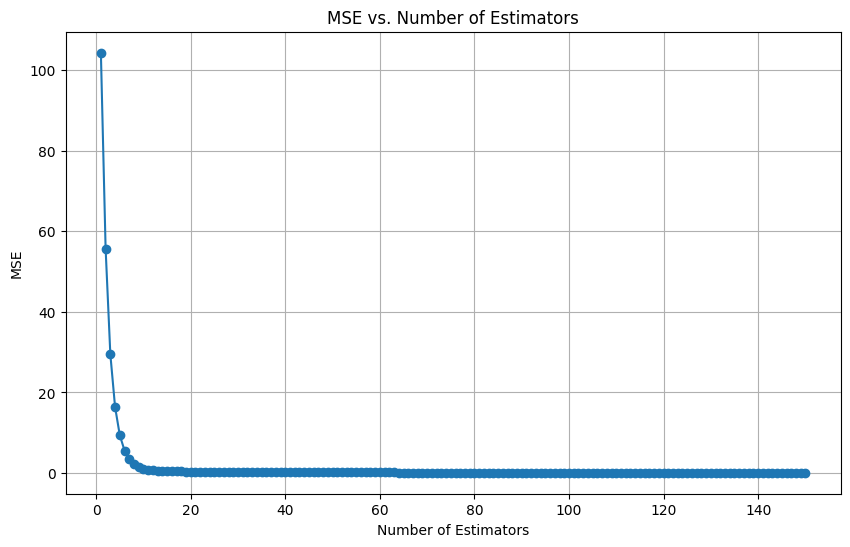

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 151), mse_values, marker='o')
plt.title('MSE vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

# 모델 성능 시각화

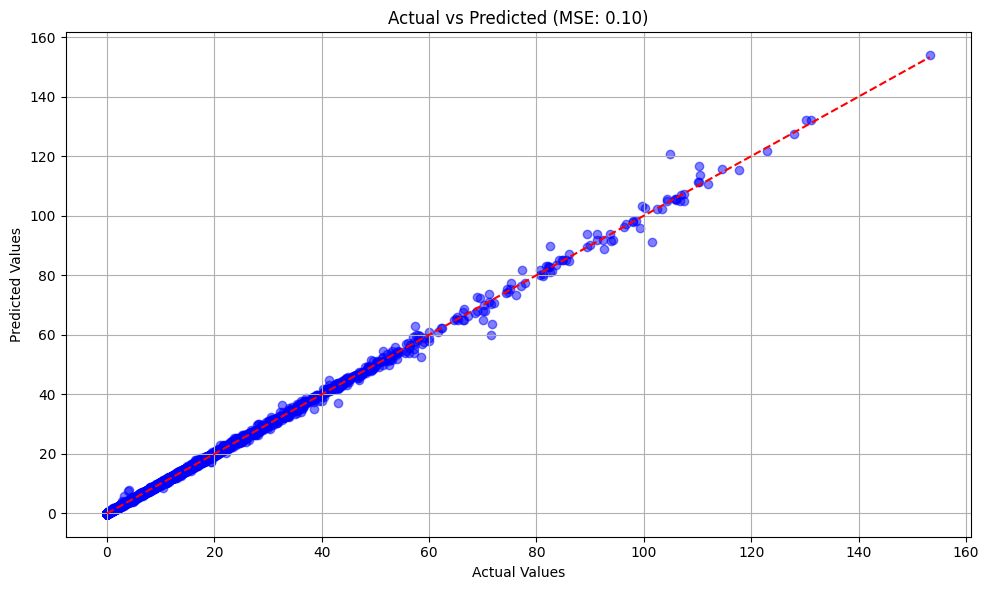

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_all, y_pred_all, color='blue', alpha=0.5)
plt.plot([y_test_all.min(), y_test_all.max()], [y_test_all.min(), y_test_all.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted (MSE: {mse_all:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Predict on the data_without_sampled dataset using the model trained with all features
predictions_all_features = rgb_regressor_all_features.predict(data_without_sampled[all_features])

# Add the new predictions to the dataframe
data_without_sampled['Predicted_일일전기사용량'] = predictions_all_features

data_without_sampled[['평균기온(°C)', '평균상대습도(%)', '일일전기사용량', 'Predicted_일일전기사용량']]

,평균기온(°C),평균상대습도(%),일일전기사용량,Predicted_일일전기사용량
0,-0.9,56,90.160222,91.273979
1,1.0,59,92.428000,92.143028
2,6.3,45,78.791778,79.603226
3,13.3,55,80.929111,80.018753
4,18.9,53,75.639556,75.553200
...,...,...,...,...
90507,23.9,68,13.052254,12.827009
90508,24.1,77,12.663260,12.579038
90509,26.5,85,16.228249,15.899596
90510,8.0,64,12.527463,12.499939


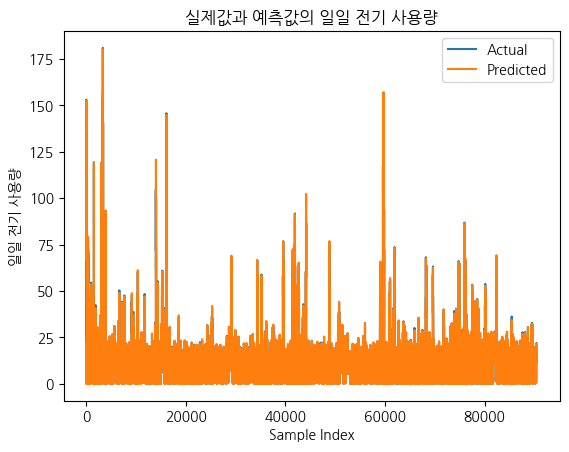

In [15]:
import koreanize_matplotlib
plt.plot(data_without_sampled['일일전기사용량'], label="Actual")
plt.plot(data_without_sampled['Predicted_일일전기사용량'], label="Predicted")
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("일일 전기 사용량")
plt.title("실제값과 예측값의 일일 전기 사용량")
plt.show()


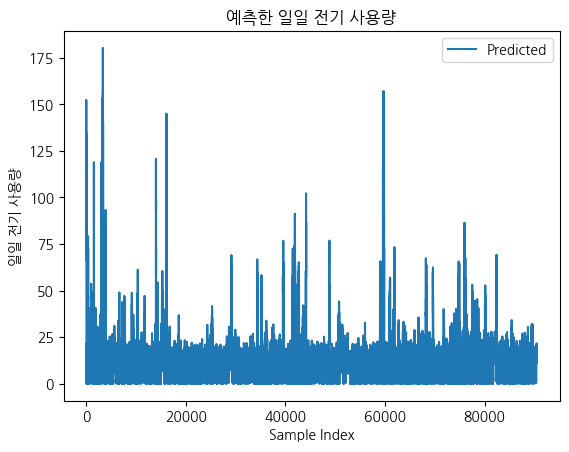

In [16]:
plt.plot(data_without_sampled['Predicted_일일전기사용량'], label="Predicted")
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("일일 전기 사용량")
plt.title("예측한 일일 전기 사용량")
plt.show()


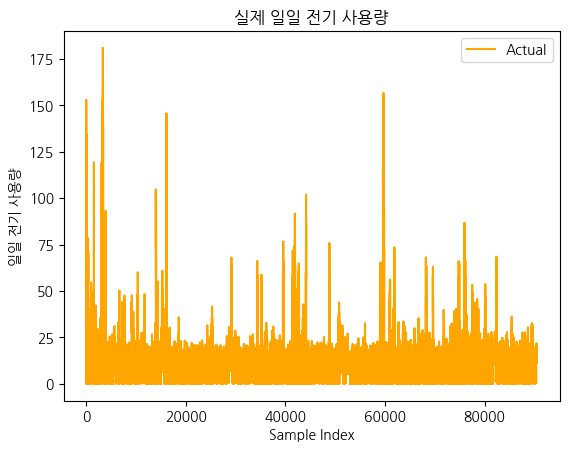

In [17]:
plt.plot(data_without_sampled['일일전기사용량'], label="Actual", color="orange")
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("일일 전기 사용량")
plt.title("실제 일일 전기 사용량")
plt.show()

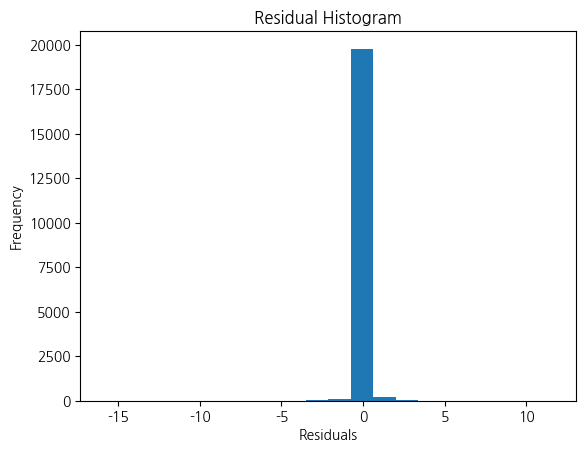

In [18]:
residuals = y_test_all - y_pred_all
plt.hist(residuals, bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Histogram")
plt.show()


# 기존 모델 성능 높이기 - 그리드 서치

In [19]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': [0.1, 0.3, 0.01, 0.001],
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [100, 150, 200],
    'random_state': [30,40,42,50]
}

In [ ]:
grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=5,  verbose=2)
grid_search.fit(X_train_all, y_train_all)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, random_state=30; total time=   6.8s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, random_state=30; total time=   3.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, random_state=30; total time=   2.6s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, random_state=30; total time=   2.6s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, random_state=30; total time=   5.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, random_state=40; total time=   2.6s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, random_state=40; total time=   2.7s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, random_state=40; total time=   2.7s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, random_state=40; total time=   5.0s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, random_state=40; total 

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.3, 0.01, 0.001],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [100, 150, 200],
                         'random_state': [30, 40, 42, 50]},
             verbose=2)

In [ ]:
results = grid_search.cv_results_
params = results['params']
mean_test_scores = results['mean_test_score']

In [ ]:
params

[{'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 100,
  'random_state': 30},
 {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 100,
  'random_state': 40},
 {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 100,
  'random_state': 42},
 {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 100,
  'random_state': 50},
 {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 150,
  'random_state': 30},
 {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 150,
  'random_state': 40},
 {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 150,
  'random_state': 42},
 {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 150,
  'random_state': 50},
 {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 200,
  'random_state': 30},
 {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 200,
  'random_state': 40},
 {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 200,
  'random_state': 42},
 {'learning_rate': 0.1,
  'max_d

In [ ]:
mean_test_scores

array([ 0.98849705,  0.98849705,  0.98849705,  0.98849705,  0.99266013,
        0.99266013,  0.99266013,  0.99266013,  0.99453155,  0.99453155,
        0.99453155,  0.99453155,  0.9945521 ,  0.9945521 ,  0.9945521 ,
        0.9945521 ,  0.99654406,  0.99654406,  0.99654406,  0.99654406,
        0.99738176,  0.99738176,  0.99738176,  0.99738176,  0.99668846,
        0.99668846,  0.99668846,  0.99668846,  0.99770747,  0.99770747,
        0.99770747,  0.99770747,  0.99814726,  0.99814726,  0.99814726,
        0.99814726,  0.99813085,  0.99813085,  0.99813085,  0.99813085,
        0.99854412,  0.99854412,  0.99854412,  0.99854412,  0.99873305,
        0.99873305,  0.99873305,  0.99873305,  0.99336129,  0.99336129,
        0.99336129,  0.99336129,  0.99548153,  0.99548153,  0.99548153,
        0.99548153,  0.99654918,  0.99654918,  0.99654918,  0.99654918,
        0.99659385,  0.99659385,  0.99659385,  0.99659385,  0.99762409,
        0.99762409,  0.99762409,  0.99762409,  0.9981061 ,  0.99

# 그리드 서치로 찾는 최적의 파라미터

<ipython-input-24-190e8be186aa>:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


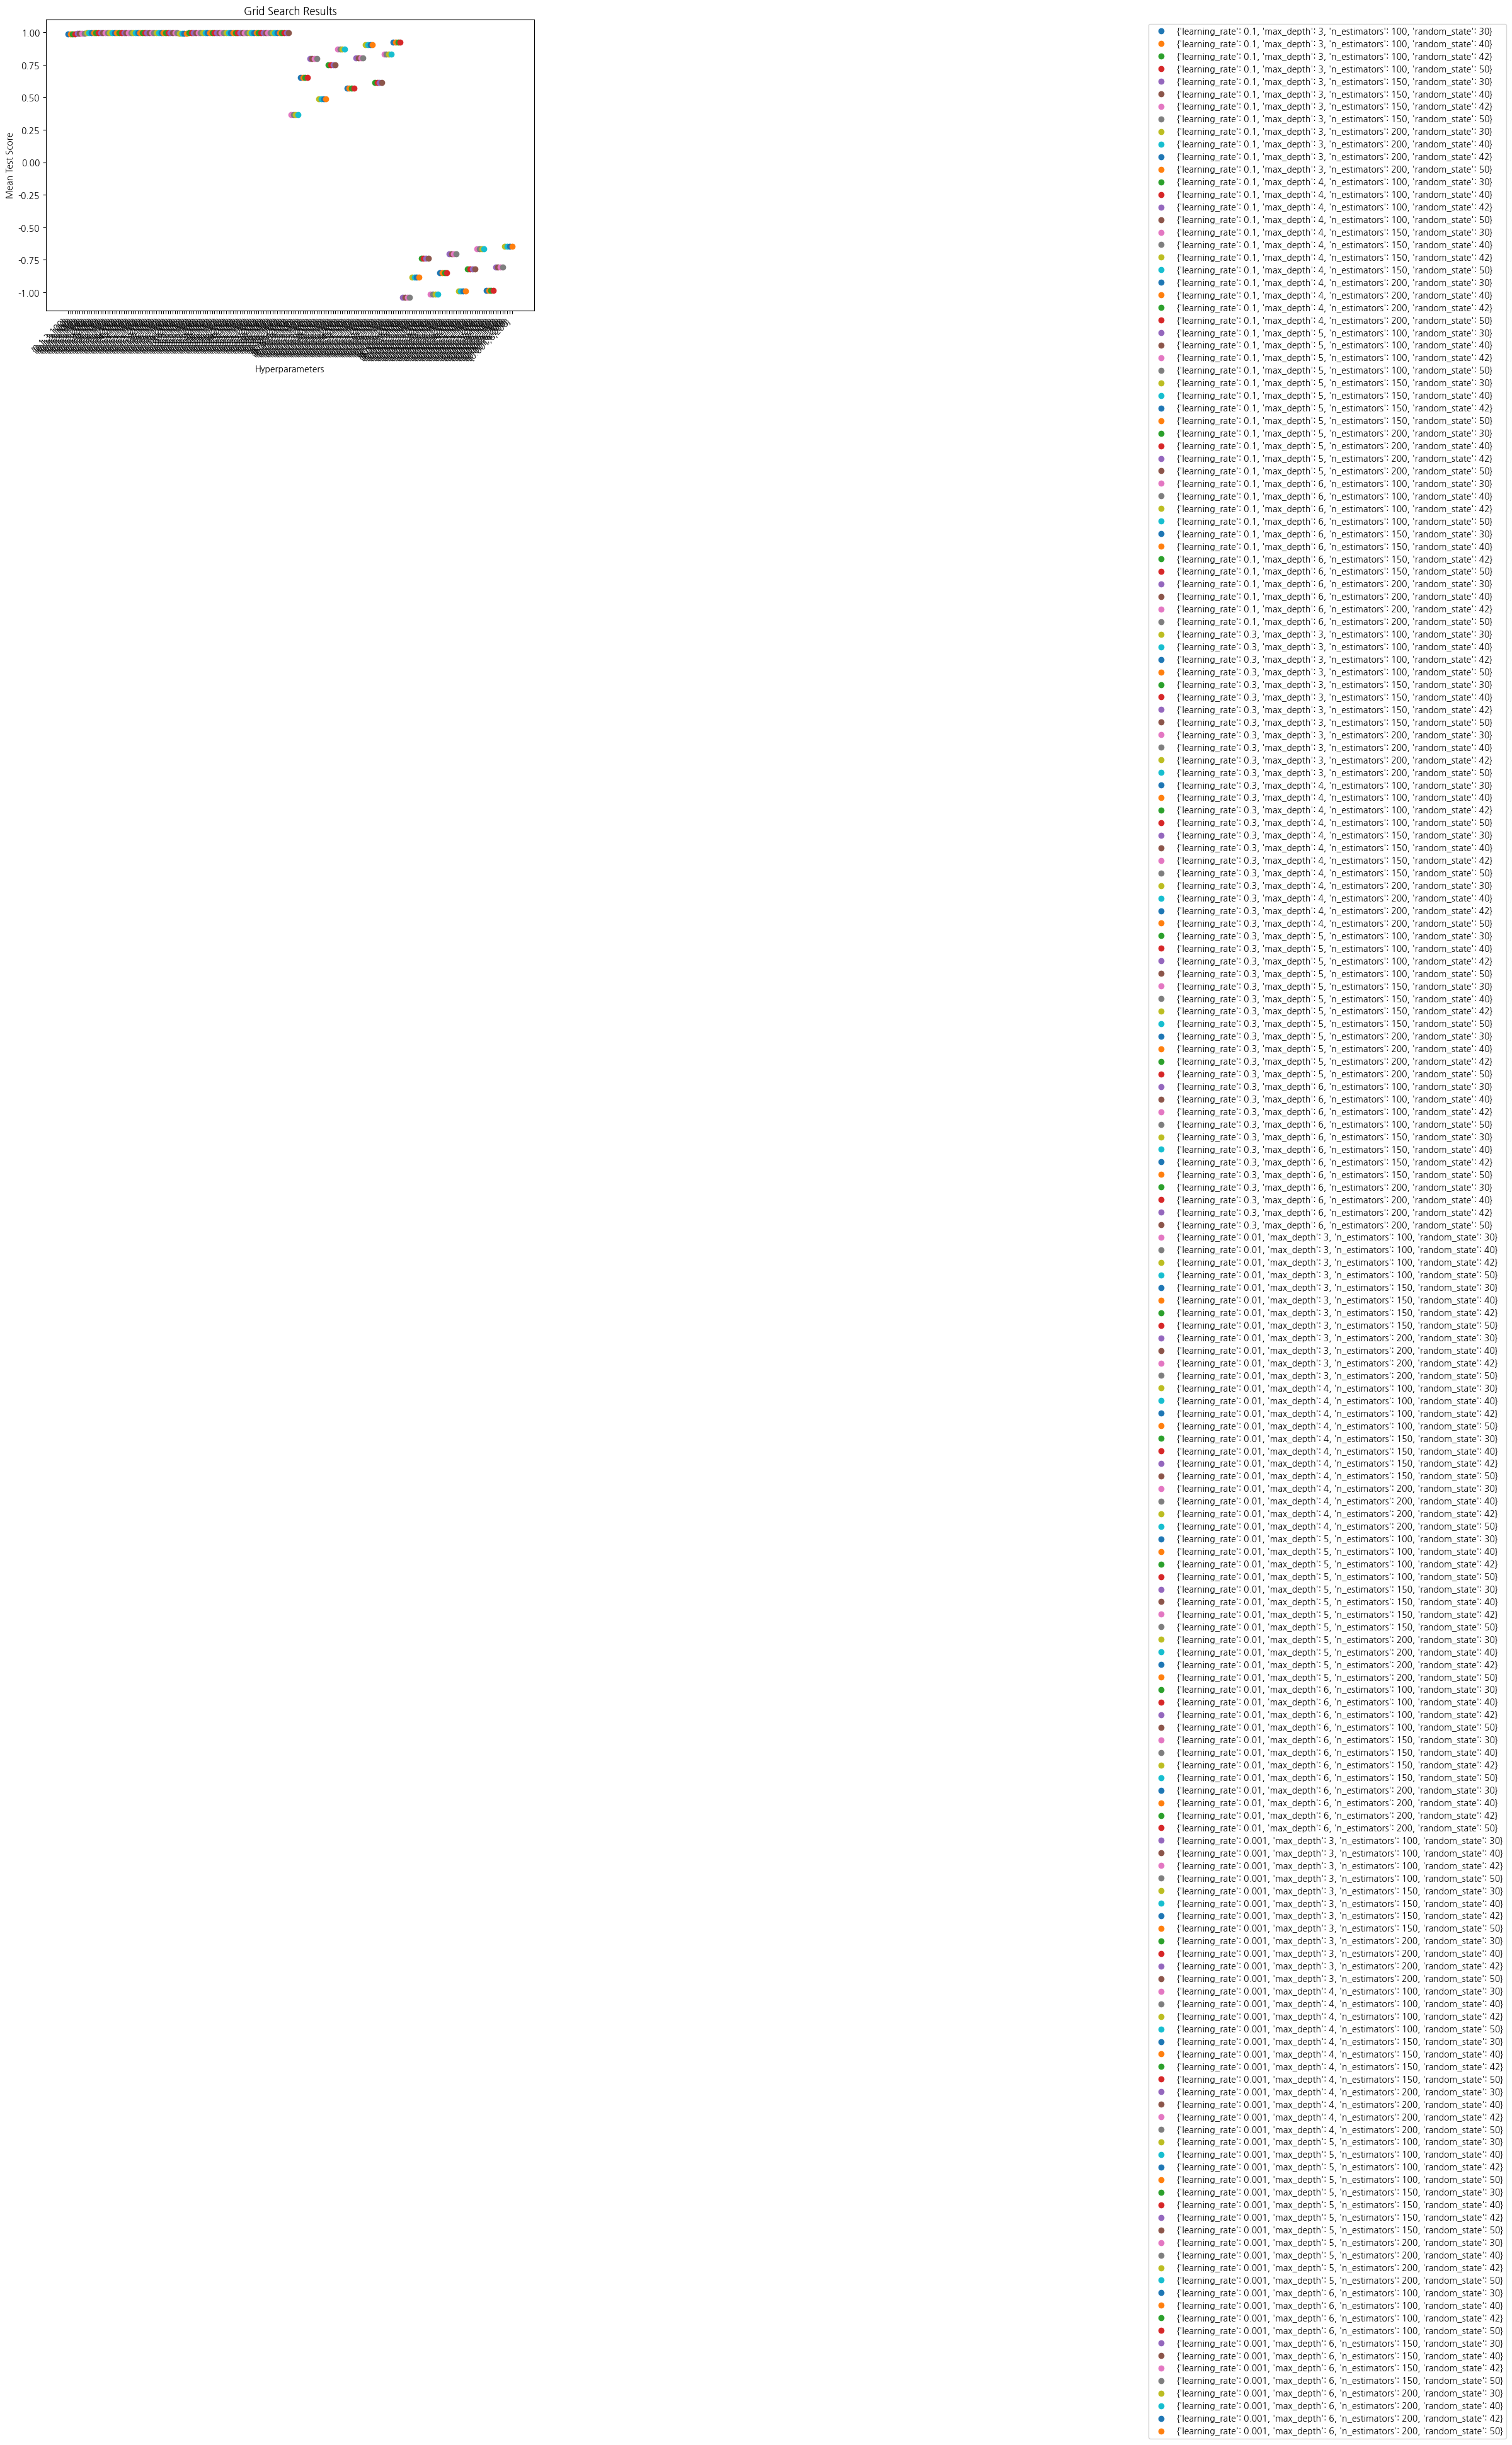

In [ ]:
arr_par = []
plt.figure(figsize=(10, 6))
for i, param in enumerate(params):
  learning_rate = param['learning_rate']
  max_depth = param['max_depth']
  n_estimators = param['n_estimators']
  st = "{" + str(learning_rate) + "," + str(max_depth) + "," + str(n_estimators) + "}"
  arr_par.append(st)
  plt.scatter(i, mean_test_scores[i], label = str(param))

plt.xticks(range(len(params)), [str(param) for param in arr_par], rotation=45, ha='right')
plt.xlabel('Hyperparameters')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Results')
plt.legend(loc='upper right', bbox_to_anchor=(3, 1))
plt.tight_layout()
plt.show()


In [ ]:
# 최적의 하이퍼파라미터 조합의 인덱스 가져오기
best_idx = mean_test_scores.argmax()

# 해당 인덱스의 하이퍼파라미터 조합
best_params = params[best_idx]

# XGBoost 모델 생성 및 학습
#best_xgb_model = XGBRegressor(**best_params)
#best_xgb_model.fit(X_train_all, y_train_all)

# 테스트 데이터에 대한 예측
#y_pred_gr = best_xgb_model.predict(X_test_all)

# 평균 제곱 오차 계산 (MSE)
#mse_grid = mean_squared_error(y_test_all, y_pred_gr)
#print(f"Mean Squared Error: {mse}")


In [ ]:
best_params

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'random_state': 30}

In [ ]:
rgb_regressor_all_features_grid = XGBRegressor(learning_rate = 0.1, max_depth = 6, n_estimators = 200, random_state = 30)
rgb_regressor_all_features_grid.fit(X_train_all, y_train_all)

y_pred_all_grid = rgb_regressor_all_features_grid.predict(X_test_all)

mse_grid = mean_squared_error(y_test_all, y_pred_all_grid)
print(f"Mean Squared Error: {mse_grid}")

Mean Squared Error: 0.07489104817414123


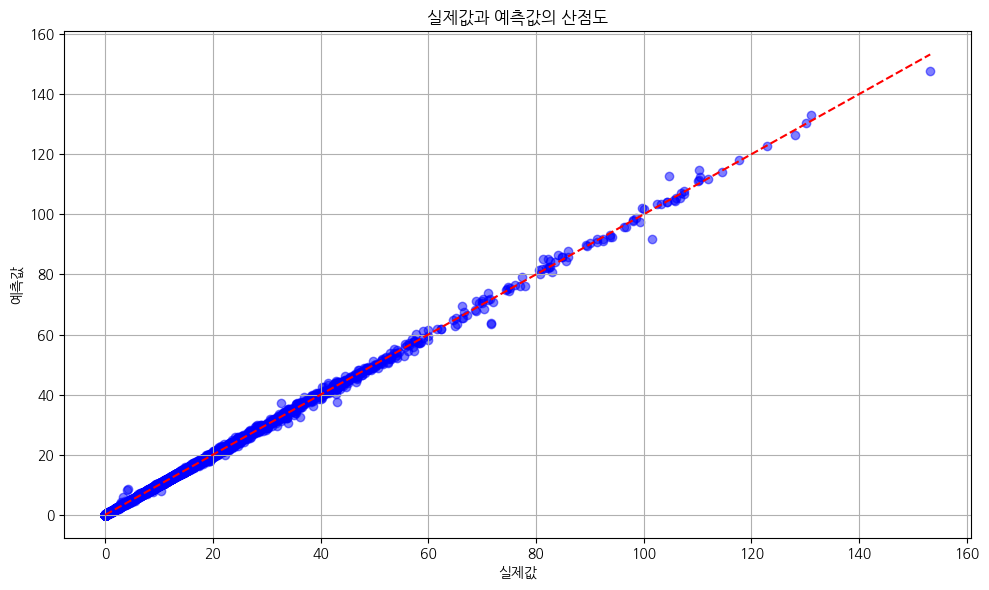

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_all, y_pred_all_grid, color='blue', alpha=0.5)
plt.plot([y_test_all.min(), y_test_all.max()], [y_test_all.min(), y_test_all.max()], 'r--')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('실제값과 예측값의 산점도')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
mse_values_grid = []
for n_estimators in range(1, 151):
    rgb_regressor_all_features.set_params(n_estimators=n_estimators,random_state=42)
    rgb_regressor_all_features.fit(X_train_all, y_train_all)
    y_pred_all_grid = rgb_regressor_all_features.predict(X_test_all)
    mse_grid = mean_squared_error(y_test_all, y_pred_all_grid)
    mse_values_grid.append(mse_grid)

In [ ]:
residuals = y_test_all - y_pred_all_grid
plt.hist(residuals, bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Histogram")
plt.show()

In [ ]:
# Predict on the data_without_sampled dataset using the model trained with all features
predictions_all_features_grid = rgb_regressor_all_features_grid.predict(data_without_sampled[all_features])

data_grid = data_without_sampled.copy()
# Add the new predictions to the dataframe
data_grid['Predicted_일일전기사용량'] = predictions_all_features_grid

data_grid[['평균기온(°C)', '평균상대습도(%)', '일일전기사용량', 'Predicted_일일전기사용량']]

# 학습데이터 특징의 중요도

In [ ]:
import koreanize_matplotlib
from xgboost import plot_importance
plot_importance(best_xgb_model)
plt.show()

# 앙상블 기법 - 기존의 그리드 서치로 튜닝한 모델에 랜덤 포레스트 조합시키기

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10)

ensemble_model = VotingRegressor(estimators=[('xgb_grid', best_xgb_model), ('rf', rf_model)])


rf_model.fit(X_train_all, y_train_all)


ensemble_model.fit(X_train_all, y_train_all)


ensemble_predictions = ensemble_model.predict(X_test_all)
print(ensemble_predictions)

In [ ]:
predictions_all_features

In [ ]:
# Predict on the data_without_sampled dataset using the model trained with all features
predictions_all_features_ensemble = ensemble_model.predict(data_without_sampled[all_features])

data_without_sampled_ensemble = data_without_sampled.copy()
# Add the new predictions to the dataframe
data_without_sampled_ensemble['Predicted_일일전기사용량'] = predictions_all_features_ensemble

data_without_sampled_ensemble[['평균기온(°C)', '평균상대습도(%)', '일일전기사용량', 'Predicted_일일전기사용량']]

In [ ]:
plt.plot(data_without_sampled_ensemble['일일전기사용량'], label="Actual")
plt.plot(data_without_sampled_ensemble['Predicted_일일전기사용량'], label="Predicted")
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("일일 전기 사용량")
plt.title("실제값과 예측값의 일일 전기 사용량")
plt.show()

In [ ]:
plt.plot(data_without_sampled_ensemble['일일전기사용량'], label="Actual")
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("일일 전기 사용량")
plt.title("실제값과 예측값의 일일 전기 사용량")
plt.show()

In [ ]:
plt.plot(data_without_sampled_ensemble['일일전기사용량'], label="Actual", color="orange")
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("일일 전기 사용량")
plt.title("실제 일일 전기 사용량")
plt.show()

In [ ]:
rgb_regressor_all_features = XGBRegressor(n_estimators=150, random_state=42)
rgb_regressor_all_features.fit(X_train_all, y_train_all)
y_pred_all = rgb_regressor_all_features.predict(X_test_all)
mse_all = mean_squared_error(y_test_all, y_pred_all)

mse_all

In [ ]:
residuals = y_test_all - y_pred_all
plt.hist(residuals, bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Histogram")
plt.show()